In [59]:
from time import time
import json
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod


In [60]:
class BlosumMatrix:
    def __init__(self, json_filename, matrix_type):
        self.blosum_matrix = self.load_blosum_from_json(json_filename, matrix_type)
        

    def load_blosum_from_json(self, json_filename, matrix_type):
        with open(json_filename, 'r') as json_file:
            data = json.load(json_file)
            blosum_matrix = data[0].get(matrix_type, {})
        return blosum_matrix

    def get_score(self, amino1, amino2):
        return self.blosum_matrix.get(amino1, {}).get(amino2, 0)

In [61]:
def create_dot_plot(alignment1, alignment2, type_align=""):
    matrix1 = np.array(list(alignment1))
    matrix2 = np.array(list(alignment2))

    matching_positions = np.where(matrix1 == matrix2)
    plt.figure(figsize=(len(alignment1) / 2, len(alignment2) / 2))

    plt.plot(matching_positions[0], matching_positions[0], 'ko', markersize=3)

    plt.xticks(range(len(alignment1)), alignment1)
    plt.yticks(range(len(alignment2)), alignment2)

    plt.title(f"Alineamiento {type_align}")
    plt.grid(True)
    plt.show()

def calcular_tiempo_ejecucion(func):
    def wrapper(*args, **kwargs):
        start_time = time()
        resultado = func(*args, **kwargs)
        end_time = time()
        tiempo_ejecucion = end_time - start_time
        print(f"Tiempo de ejecución de {func.__name__}: {tiempo_ejecucion} segundos")
        return resultado
    return wrapper


## Alineación Global - El Algoritmo de Needleman-Wunsch
    - Sin BLOSUM
    - Con BLOSUM

In [62]:
class Alignment(ABC):
    def __init__(self, seq1, seq2):
        self.seq1 = seq1
        self.seq2 = seq2

    @abstractmethod
    def align(self):
        pass

class NeedlemanWunsch(Alignment):
    def __init__(self, seq1, seq2, gap_penalty, match_score, mismatch_penalty, blosum_matrix=None):
        self.seq1 = seq1
        self.seq2 = seq2
        self.gap_penalty = gap_penalty
        self.match_score = match_score
        self.mismatch_penalty = mismatch_penalty
        self.blosum_matrix = blosum_matrix
    
    def calculate_score_matrix(self):
        m, n = len(self.seq1), len(self.seq2)
        F = np.zeros((m + 1, n + 1), dtype=int)

        for i in range(1, m + 1):
            F[i][0] = self.gap_penalty * i
        for j in range(1, n + 1):
            F[0][j] = self.gap_penalty * j

        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if self.blosum_matrix:
                    match_ = F[i - 1][j - 1] + self.blosum_matrix.get_score(self.seq1[i - 1], self.seq2[j - 1])
                else:
                    match_ = F[i - 1][j - 1] + (self.match_score if self.seq1[i - 1] == self.seq2[j - 1] else self.mismatch_penalty)
                delete = F[i - 1][j] + self.gap_penalty
                insert = F[i][j - 1] + self.gap_penalty
                F[i][j] = max(match_, delete, insert)

        return F

    def trace_back(self, F):
        m, n = len(self.seq1), len(self.seq2)
        alignment1, alignment2 = '', ''
        i, j = m, n

        while i > 0 or j > 0:
            if i > 0 and j > 0:
                if self.blosum_matrix:
                    if F[i][j] == F[i - 1][j - 1] + self.blosum_matrix.get_score(self.seq1[i - 1], self.seq2[j - 1]):
                        alignment1 = self.seq1[i - 1] + alignment1
                        alignment2 = self.seq2[j - 1] + alignment2
                        i -= 1
                        j -= 1
                    else:
                        if F[i][j] == F[i - 1][j] + self.gap_penalty:
                            alignment1 = self.seq1[i - 1] + alignment1
                            alignment2 = '-' + alignment2
                            i -= 1
                        else:
                            alignment1 = '-' + alignment1
                            alignment2 = self.seq2[j - 1] + alignment2
                            j -= 1
                else:
                    if F[i][j] == F[i - 1][j - 1] + (self.match_score if self.seq1[i - 1] == self.seq2[j - 1] else self.mismatch_penalty):
                        alignment1 = self.seq1[i - 1] + alignment1
                        alignment2 = self.seq2[j - 1] + alignment2
                        i -= 1
                        j -= 1
                    else:
                        if F[i][j] == F[i - 1][j] + self.gap_penalty:
                            alignment1 = self.seq1[i - 1] + alignment1
                            alignment2 = '-' + alignment2
                            i -= 1
                        else:
                            alignment1 = '-' + alignment1
                            alignment2 = self.seq2[j - 1] + alignment2
                            j -= 1
            else:
                if i > 0:
                    alignment1 = self.seq1[i - 1] + alignment1
                    alignment2 = '-' + alignment2
                    i -= 1
                else:
                    alignment1 = '-' + alignment1
                    alignment2 = self.seq2[j - 1] + alignment2
                    j -= 1

        return alignment1, alignment2

    def align(self):
        score_matrix = self.calculate_score_matrix()
        aligned_seq1, aligned_seq2 = self.trace_back(score_matrix)
        return aligned_seq1, aligned_seq2

In [63]:
#seq1 = "GTGGGTTAGCTAGGTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGT"
#seq2 = "TAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGCTAGGTTTAGC"

#seq1 =  "ARNDCEQGH"
#seq2 = "ARNDCDEQH"

#seq1 = "AGCCT"
#seq2 = "ACCT"

seq1 = "ATCGATCGTACGTACG"
seq2 = "ACGTACGATCGTACGA"

gap_penalty = -2
match_score = 1
mismatch_penalty = -1

json_filename = "blosum.json"
matrix_type = "90"
blosum_scorer = BlosumMatrix(json_filename, matrix_type)
alignment = NeedlemanWunsch(seq1, seq2, gap_penalty, match_score, mismatch_penalty, blosum_matrix=blosum_scorer)
alignment1, alignment2  = alignment.align()

print("Alignment 1:", alignment1)
print("Alignment 2:", alignment2)

Alignment 1: ATCGAT-CG-TACGTACG-
Alignment 2: A-CG-TACGAT-CGTACGA


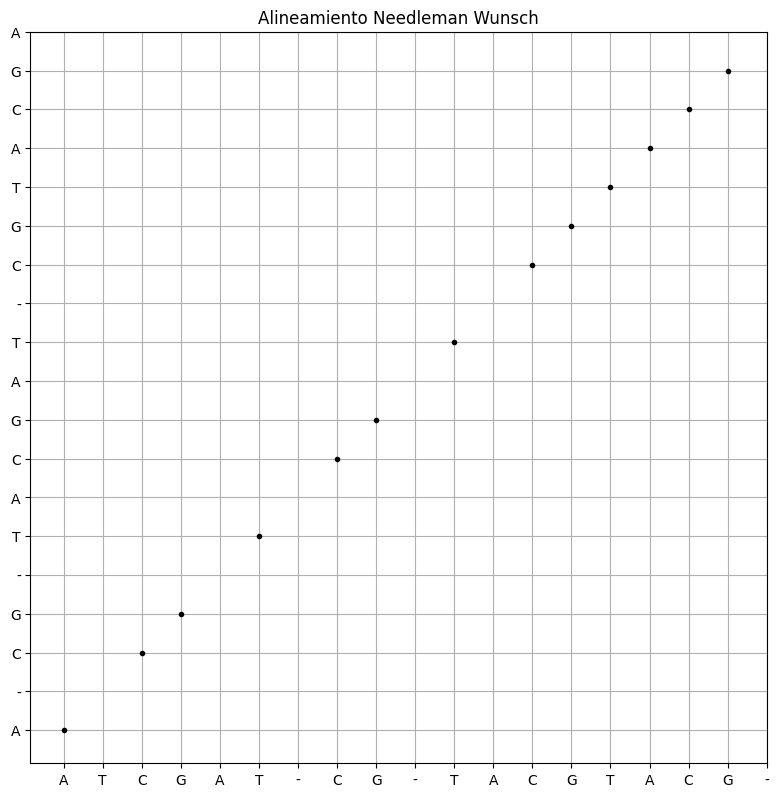

In [64]:
create_dot_plot(alignment1, alignment2, type_align="Needleman Wunsch")


In [65]:
class SmithWaterman(Alignment):
    def __init__(self, seq1, seq2, match=2, mismatch=0, gap=0, blosum_matrix=None):
        super().__init__(seq1, seq2)
        self.match = match
        self.mismatch = mismatch
        self.gap = gap
        self.blosum_matrix = blosum_matrix
    
    def calculate_score_matrix(self):
        matrix = [[0] * (len(self.seq2) + 1) for _ in range(len(self.seq1) + 1)]

        max_score = 0
        max_i, max_j = 0, 0

        for i in range(1, len(self.seq1) + 1):
            for j in range(1, len(self.seq2) + 1):
                if self.blosum_matrix:
                    score = matrix[i - 1][j - 1] + self.blosum_matrix.get_score(self.seq1[i - 1], self.seq2[j - 1])
                else:
                    if self.seq1[i - 1] == self.seq2[j - 1]:
                        score = matrix[i - 1][j - 1] + self.match
                    else:
                        score = matrix[i - 1][j - 1] + self.mismatch

                score = max(0, score, matrix[i - 1][j] + self.gap, matrix[i][j - 1] + self.gap)
                matrix[i][j] = score

                if score > max_score:
                    max_score = score
                    max_i, max_j = i, j

        return matrix, max_i, max_j

    def trace_back(self, score_matrix, max_i, max_j):
        aligned_seq1, aligned_seq2 = "", ""
        i, j = max_i, max_j

        while score_matrix[i][j] != 0:
            if i > 0 and j > 0 and score_matrix[i][j] == score_matrix[i - 1][j - 1] + (self.match if self.seq1[i - 1] == self.seq2[j - 1] else self.mismatch):
                aligned_seq1 = self.seq1[i - 1] + aligned_seq1
                aligned_seq2 = self.seq2[j - 1] + aligned_seq2
                i -= 1
                j -= 1
            elif i > 0 and score_matrix[i][j] == score_matrix[i - 1][j] + self.gap:
                aligned_seq1 = self.seq1[i - 1] + aligned_seq1
                aligned_seq2 = "-" + aligned_seq2
                i -= 1
            else:
                aligned_seq1 = "-" + aligned_seq1
                aligned_seq2 = self.seq2[j - 1] + aligned_seq2
                j -= 1

        return aligned_seq1, aligned_seq2

    def align(self):
        score_matrix, max_i, max_j = self.calculate_score_matrix()
        aligned_seq1, aligned_seq2 = self.trace_back(score_matrix, max_i, max_j)
        return aligned_seq1, aligned_seq2
    
seq1 = "ATCGATCGTACGTACG"
seq2 = "ACGTACGATCGTACGA"
blosum_scorer = BlosumMatrix(json_filename, matrix_type)
local_alignment = SmithWaterman(seq1, seq2, match=1)
aligned_seq1, aligned_seq2 = local_alignment.align()
print("Secuencia 1 alineada:", aligned_seq1)
print("Secuencia 2 alineada:", aligned_seq2)

Secuencia 1 alineada: A--T-CGATCGTACGTA
Secuencia 2 alineada: ACGTACGATCGTACG-A


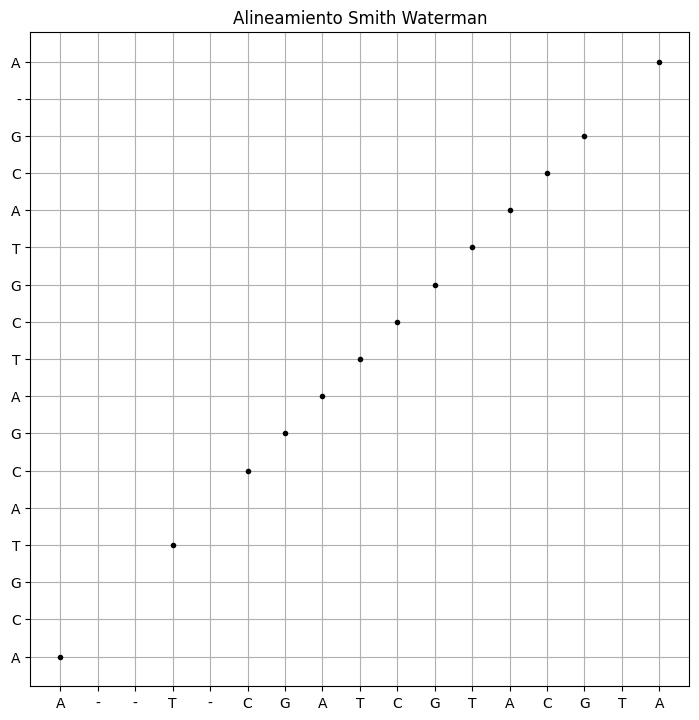

In [66]:
create_dot_plot(aligned_seq1, aligned_seq2, type_align="Smith Waterman")

In [75]:
import time
import json

local_alignment_times = []
global_alignment_times = []

def calcular_tiempo_ejecucion(times_list):
    def decorator(func):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            resultado = func(*args, **kwargs)
            end_time = time.time()
            tiempo_ejecucion = end_time - start_time
            times_list.append(tiempo_ejecucion)
            return resultado
        return wrapper
    return decorator

@calcular_tiempo_ejecucion(local_alignment_times)
def local_alignment_algorithm(local_alignment):
    local_alignment.calculate_score_matrix()

@calcular_tiempo_ejecucion(global_alignment_times)
def global_alignment_algorithm(global_alignment):
    
    global_alignment.calculate_score_matrix()

with open("protein.json", "r") as json_file:
    data = json.load(json_file)

gap_penalty = -1
match_score = 1
mismatch_penalty = -1

for protein in data:
    seq1 = protein[0]["protein1"]
    seq2 = protein[1]["protein2"]
    global_alignment = NeedlemanWunsch(seq1, seq2, gap_penalty, match_score, mismatch_penalty)
    local_alignment = SmithWaterman(seq1, seq2, match=1)

    global_alignment_algorithm(global_alignment)
    local_alignment_algorithm(local_alignment)

average_local_time = sum(local_alignment_times) / len(local_alignment_times)
average_global_time = sum(global_alignment_times) / len(global_alignment_times)

print(f"Tiempo promedio de ejecución para local_alignment.align(): {average_local_time} segundos")
print(f"Tiempo promedio de ejecución para global_alignment.align(): {average_global_time} segundos")


Tiempo promedio de ejecución para local_alignment.align(): 0.035642147064208984 segundos
Tiempo promedio de ejecución para global_alignment.align(): 0.08045083284378052 segundos
